In [1]:
# from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from selenium.webdriver.chrome.options import Options
import os
import json
import re
import datetime
import sys
import pandas as pd
import datetime

try: 
    from pyvirtualdisplay import Display
except  ModuleNotFoundError:
    !pip install PyVirtualDisplay
    
try: 
    from seleniumwire import webdriver  # Import from seleniumwire
except  ModuleNotFoundError:
    print("module selenium-wire is not installed, now start installation.")
    !pip install selenium-wire

In [2]:
# For mouse scroll
def wheel_element(element, deltaX = 0, deltaY = 120, offsetX = 0, offsetY = 0):
    error = element._parent.execute_script("""
    var element = arguments[0];
    var deltaX = arguments[1]
    var deltaY = arguments[2];
    var box = element.getBoundingClientRect();
    var clientX = box.left + (arguments[3] || box.width / 2);
    var clientY = box.top + (arguments[4] || box.height / 2);
    var target = element.ownerDocument.elementFromPoint(clientX, clientY);

    for (var e = target; e; e = e.parentElement) {
      if (e === element) {
        target.dispatchEvent(new MouseEvent('mouseover', {view: window, bubbles: true, cancelable: true, clientX: clientX, clientY: clientY}));
        target.dispatchEvent(new MouseEvent('mousemove', {view: window, bubbles: true, cancelable: true, clientX: clientX, clientY: clientY}));
        target.dispatchEvent(new WheelEvent('wheel',     {view: window, bubbles: true, cancelable: true, clientX: clientX, clientY: clientY, deltaX: deltaX, deltaY: deltaY}));
        return;
      }
    }    
    return "Element is not interactable";
    """, element, deltaX, deltaY, offsetY)

def get_websocket_data(ticker, interval, monitor=True):
    # Initiate a chrome web driver
    chrm_options = Options()
    chrm_caps = webdriver.DesiredCapabilities.CHROME.copy()
    chrm_caps['goog:loggingPrefs'] = { 'performance':'ALL' } #save all returns including websocket data
    
    if monitor == False:
        display = Display(visible=0, size=(1024, 768)) 
        display.start()
    
    driver = webdriver.Chrome(chrome_options=chrm_options,
                              desired_capabilities=chrm_caps) 

    driver.maximize_window()
    # Go to Trading View
    website = 'https://www.tradingview.com/'
    driver.get(website)
    print('Reached tradingview website')
    
    # Input query
    driver.find_element_by_tag_name('body').send_keys(Keys.COMMAND + 'k')
    driver.implicitly_wait(3)

    query = driver.find_element_by_name('query')
    query.send_keys(ticker)
    print('Typed in ticker name')
    driver.implicitly_wait(3)

#     query.submit()
    query.send_keys(Keys.ENTER)
    print('Pressed search')
    driver.implicitly_wait(3)
    
    # Select frequency
    control = driver.find_element_by_id('header-toolbar-intervals')
    control.click()
    
    if interval == "1h":
        select_1h = driver.find_element_by_xpath("//div[@data-value='60']")
        select_1h.click()
        print('Selected 1h interval')

#         driver.refresh()
        
    # Scroll the chart to retrieve all data    
    elm = driver.find_element_by_class_name('chart-gui-wrapper')
    for i in range(500):
        wheel_element(elm, deltaX=0, deltaY=100)
    print('Zoomed out')

    for i in range(500):
        wheel_element(elm, deltaX=-10, deltaY=0)
    print('Zoomed left')
    driver.close()
    print('Done!')
    
    if monitor == False:
        display.end()
        
    return driver.requests

def parse_driver_requests(driver_requests):
    ws = []
    for request in driver_requests:
        if request.ws_messages:
            ws.append(request.ws_messages)
            
    messages = []
    for w in ws:
        for l in w:
            m = l.content
            txt_list = re.split('~m~\d*~m~',m)       
            for t in txt_list:
                if len(t)<10:
                    continue
                t = json.loads(t)
                try:
                    if t['m'] == 'timescale_update':
                        messages.append(t)
                except:
                    continue
                    
    price_data = []

    for m in messages[1:]:
        try:
            _j = m['p'][1]
            price_data.append([s['v']  for s in _j['sds_1']['s']])
        except:
            continue
            
    if len(price_data)==0:
        print('ticker not avaliable')
        return None
    df = [pd.DataFrame(p) for p in price_data]
    df = pd.concat(df)

    df.columns = ['Date', 'open', 'high', 'low', 'close', 'volume']
    df.Date = pd.to_datetime(df.Date, unit='s')
    
    print('before drop duplicate', len(df))
    df = df.drop_duplicates('Date', keep='last')
    df.sort_values('Date', inplace=True)
    print('after',len(df))
    df.reset_index(inplace=True, drop=True)
    return df

In [3]:
months = 'FGHJKMNQUVXZ'
years = ['2018', '2019', '2020', '2021', '2022', '2023']
symbols = ['BTC', 'ETH']
exchanges = ['CME']

monthsN = ['01','02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
queries = []
monthDict = {months[i]: monthsN[i] for i in range(len(months))}


for e in exchanges:
    for s in symbols:
        for m in months:
            for y in years:
                queries.append(e+':'+s+m+y)

queries

['CME:BTCF2018',
 'CME:BTCF2019',
 'CME:BTCF2020',
 'CME:BTCF2021',
 'CME:BTCF2022',
 'CME:BTCF2023',
 'CME:BTCG2018',
 'CME:BTCG2019',
 'CME:BTCG2020',
 'CME:BTCG2021',
 'CME:BTCG2022',
 'CME:BTCG2023',
 'CME:BTCH2018',
 'CME:BTCH2019',
 'CME:BTCH2020',
 'CME:BTCH2021',
 'CME:BTCH2022',
 'CME:BTCH2023',
 'CME:BTCJ2018',
 'CME:BTCJ2019',
 'CME:BTCJ2020',
 'CME:BTCJ2021',
 'CME:BTCJ2022',
 'CME:BTCJ2023',
 'CME:BTCK2018',
 'CME:BTCK2019',
 'CME:BTCK2020',
 'CME:BTCK2021',
 'CME:BTCK2022',
 'CME:BTCK2023',
 'CME:BTCM2018',
 'CME:BTCM2019',
 'CME:BTCM2020',
 'CME:BTCM2021',
 'CME:BTCM2022',
 'CME:BTCM2023',
 'CME:BTCN2018',
 'CME:BTCN2019',
 'CME:BTCN2020',
 'CME:BTCN2021',
 'CME:BTCN2022',
 'CME:BTCN2023',
 'CME:BTCQ2018',
 'CME:BTCQ2019',
 'CME:BTCQ2020',
 'CME:BTCQ2021',
 'CME:BTCQ2022',
 'CME:BTCQ2023',
 'CME:BTCU2018',
 'CME:BTCU2019',
 'CME:BTCU2020',
 'CME:BTCU2021',
 'CME:BTCU2022',
 'CME:BTCU2023',
 'CME:BTCV2018',
 'CME:BTCV2019',
 'CME:BTCV2020',
 'CME:BTCV2021',
 'CME:BTCV2022

In [4]:
path = './CME/'

In [5]:
ls = [l[:-4] for l in os.listdir(path) if l.endswith('.csv')]
for q in queries:
    name = q[4:]
    print(q,name,  name not in ls)

CME:BTCF2018 BTCF2018 False
CME:BTCF2019 BTCF2019 False
CME:BTCF2020 BTCF2020 False
CME:BTCF2021 BTCF2021 False
CME:BTCF2022 BTCF2022 False
CME:BTCF2023 BTCF2023 False
CME:BTCG2018 BTCG2018 False
CME:BTCG2019 BTCG2019 False
CME:BTCG2020 BTCG2020 False
CME:BTCG2021 BTCG2021 False
CME:BTCG2022 BTCG2022 False
CME:BTCG2023 BTCG2023 True
CME:BTCH2018 BTCH2018 False
CME:BTCH2019 BTCH2019 False
CME:BTCH2020 BTCH2020 False
CME:BTCH2021 BTCH2021 False
CME:BTCH2022 BTCH2022 False
CME:BTCH2023 BTCH2023 False
CME:BTCJ2018 BTCJ2018 False
CME:BTCJ2019 BTCJ2019 False
CME:BTCJ2020 BTCJ2020 False
CME:BTCJ2021 BTCJ2021 False
CME:BTCJ2022 BTCJ2022 False
CME:BTCJ2023 BTCJ2023 True
CME:BTCK2018 BTCK2018 False
CME:BTCK2019 BTCK2019 False
CME:BTCK2020 BTCK2020 False
CME:BTCK2021 BTCK2021 False
CME:BTCK2022 BTCK2022 False
CME:BTCK2023 BTCK2023 True
CME:BTCM2018 BTCM2018 False
CME:BTCM2019 BTCM2019 False
CME:BTCM2020 BTCM2020 False
CME:BTCM2021 BTCM2021 False
CME:BTCM2022 BTCM2022 False
CME:BTCM2023 BTCM2023 F

In [6]:
path+q[4:]

'./CME/ETHZ2023'

In [7]:
queries[0:1]


'CME:BTCF2023'

'CME:BTCF2023'

In [8]:
results = dict()

for q in queries:
# for q in ['CME:ETHF2017']:
    name = q[4:]
    print(q, name)
    if name not in ls:
        print('start')
        try:
            driver_requests = get_websocket_data(q, '1h', True)
            data = parse_driver_requests(driver_requests) 
            if data == None:
                data = pd.DataFrame()
            data.to_csv(path+name+'.csv')
            print('saved to ', path+name+'.csv')
            results[q] = data
        except:
            continue

CME:BTCF2018 BTCF2018
CME:BTCF2019 BTCF2019
CME:BTCF2020 BTCF2020
CME:BTCF2021 BTCF2021
CME:BTCF2022 BTCF2022
CME:BTCF2023 BTCF2023
CME:BTCG2018 BTCG2018
CME:BTCG2019 BTCG2019
CME:BTCG2020 BTCG2020
CME:BTCG2021 BTCG2021
CME:BTCG2022 BTCG2022
CME:BTCG2023 BTCG2023
start
Reached tradingview website
Typed in ticker name
Pressed search
Selected 1h interval
Zoomed out
Zoomed left
Done!
CME:BTCH2018 BTCH2018
CME:BTCH2019 BTCH2019
CME:BTCH2020 BTCH2020
CME:BTCH2021 BTCH2021
CME:BTCH2022 BTCH2022
CME:BTCH2023 BTCH2023
CME:BTCJ2018 BTCJ2018
CME:BTCJ2019 BTCJ2019
CME:BTCJ2020 BTCJ2020
CME:BTCJ2021 BTCJ2021
CME:BTCJ2022 BTCJ2022
CME:BTCJ2023 BTCJ2023
start
Reached tradingview website
Typed in ticker name
Pressed search
Selected 1h interval
Zoomed out
Zoomed left
Done!
CME:BTCK2018 BTCK2018
CME:BTCK2019 BTCK2019
CME:BTCK2020 BTCK2020
CME:BTCK2021 BTCK2021
CME:BTCK2022 BTCK2022
CME:BTCK2023 BTCK2023
start
Reached tradingview website
Typed in ticker name
Pressed search
Selected 1h interval
Zoomed ou

In [10]:
results.keys()

In [24]:
results[q] = data



In [19]:
data.to_csv(path+name+'.csv')

In [33]:
q = 'CME:ETHN2019'
driver_requests = get_websocket_data(q, '1h', True)


ws = []
for request in driver_requests:
    if request.ws_messages:
        ws.append(request.ws_messages)

messages = []
for w in ws:
    for l in w:
        m = l.content
        txt_list = re.split('~m~\d*~m~',m)       
        for t in txt_list:
            if len(t)<10:
                continue
            t = json.loads(t)
            try:
                if t['m'] == 'timescale_update':
                    messages.append(t)
            except:
                continue

Reached tradingview website
Typed in ticker name
Pressed search
Selected 1h interval
Zoomed out
Zoomed left
Done!


In [34]:
price_data = []

for m in messages[1:]:
    try:
        _j = m['p'][1]
        price_data.append([s['v']  for s in _j['sds_1']['s']])
    except:
        continue

if len(price_data)==0:
    print('ticker not avaliable')
df = [pd.DataFrame(p) for p in price_data]
df = pd.concat(df)

df.columns = ['Date', 'open', 'high', 'low', 'close', 'volume']
df.Date = pd.to_datetime(df.Date, unit='s')

print('before drop duplicate', len(df))
df = df.drop_duplicates('Date', keep='last')
df.sort_values('Date', inplace=True)
print('after',len(df))
df.reset_index(inplace=True, drop=True)

ValueError: Length mismatch: Expected axis has 0 elements, new values have 6 elements

In [32]:
df

,Date,open,high,low,close,volume
0,2022-01-26 23:00:00,2387.0,2387.0,2387.0,2387.0,0.0
1,2022-01-27 23:00:00,2566.0,2566.0,2566.0,2566.0,0.0
2,2022-01-30 23:00:00,2754.5,2754.5,2754.5,2754.5,0.0
3,2022-01-31 23:00:00,2833.5,2833.5,2833.5,2833.5,0.0
4,2022-02-01 23:00:00,2790.0,2790.0,2790.0,2790.0,0.0
...,...,...,...,...,...,...
1173,2022-07-29 10:00:00,1728.0,1730.0,1719.5,1719.5,3.0
1174,2022-07-29 11:00:00,1712.0,1712.0,1670.0,1684.0,13.0
1175,2022-07-29 12:00:00,1674.0,1676.0,1659.5,1667.0,22.0
1176,2022-07-29 13:00:00,1664.0,1703.5,1662.0,1685.5,43.0


In [25]:
messages[0]

{'m': 'timescale_update',
 'p': ['cs_C9AG7BowRaKI',
  {'sds_1': {'node': 'fra2-34-series-charts-free-2-runner-2',
    's': [{'i': 0,
      'v': [1615244400.0, 3831.25, 3901.25, 3826.25, 3873.25, 1704837.0]},
     {'i': 1,
      'v': [1615330800.0, 3878.5, 3916.25, 3856.25, 3896.5, 1845205.0]},
     {'i': 2,
      'v': [1615417200.0, 3907.75, 3958.5, 3893.0, 3936.75, 1599748.0]},
     {'i': 3,
      'v': [1615503600.0, 3928.0, 3938.5, 3900.75, 3932.75, 1596215.0]},
     {'i': 4,
      'v': [1615759200.0, 3937.5, 3960.25, 3913.0, 3958.25, 1974366.0]},
     {'i': 5,
      'v': [1615845600.0, 3957.75, 3970.75, 3942.75, 3952.5, 1973548.0]},
     {'i': 6, 'v': [1615932000.0, 3957.25, 3973.5, 3925.0, 3963.5, 1941883.0]},
     {'i': 7, 'v': [1616018400.0, 3962.0, 3978.5, 3900.5, 3906.0, 2124392.0]},
     {'i': 8,
      'v': [1616104800.0, 3910.75, 3923.5, 3875.0, 3899.75, 2047619.0]},
     {'i': 9, 'v': [1616364000.0, 3893.5, 3944.5, 3885.0, 3930.0, 1325987.0]},
     {'i': 10,
      'v': [1616

In [24]:
messages[7]

{'m': 'timescale_update',
 'p': ['cs_tAeulf6lU6gM',
  {'sds_1': {'node': 'fra2-34-series-charts-free-2-runner-1',
    's': [{'i': -27,
      'v': [1657530000.0, 20465.0, 20575.0, 20460.0, 20505.0, 121.0]},
     {'i': -26, 'v': [1657533600.0, 20485.0, 20575.0, 20460.0, 20485.0, 62.0]},
     {'i': -25,
      'v': [1657537200.0, 20495.0, 20545.0, 20380.0, 20425.0, 155.0]},
     {'i': -24,
      'v': [1657540800.0, 20410.0, 20575.0, 20360.0, 20545.0, 370.0]},
     {'i': -23,
      'v': [1657544400.0, 20545.0, 20700.0, 20215.0, 20315.0, 974.0]},
     {'i': -22,
      'v': [1657548000.0, 20305.0, 20445.0, 20240.0, 20340.0, 458.0]},
     {'i': -21,
      'v': [1657551600.0, 20335.0, 20435.0, 20300.0, 20400.0, 386.0]},
     {'i': -20,
      'v': [1657555200.0, 20400.0, 20475.0, 20360.0, 20360.0, 358.0]},
     {'i': -19,
      'v': [1657558800.0, 20385.0, 20620.0, 20370.0, 20590.0, 484.0]},
     {'i': -18,
      'v': [1657562400.0, 20590.0, 20685.0, 20535.0, 20535.0, 486.0]},
     {'i': -17,
  

In [17]:
messages[-1]

{'m': 'timescale_update',
 'p': ['cs_tAeulf6lU6gM',
  {'sds_1': {'node': 'fra2-34-series-charts-free-2-runner-1',
    's': [{'i': -1054,
      'v': [1646056800.0, 39560.0, 40055.0, 39560.0, 40055.0, 2.0]},
     {'i': -1053,
      'v': [1646064000.0, 41270.0, 41270.0, 41250.0, 41250.0, 7.0]},
     {'i': -1052,
      'v': [1646143200.0, 44600.0, 44600.0, 44600.0, 44600.0, 1.0]},
     {'i': -1051,
      'v': [1646179200.0, 44895.0, 44895.0, 44895.0, 44895.0, 1.0]},
     {'i': -1050,
      'v': [1646211600.0, 44480.0, 44480.0, 44480.0, 44480.0, 1.0]},
     {'i': -1049,
      'v': [1646229600.0, 45095.0, 45095.0, 45095.0, 45095.0, 1.0]},
     {'i': -1048,
      'v': [1646233200.0, 45265.0, 45265.0, 45265.0, 45265.0, 1.0]},
     {'i': -1047,
      'v': [1646420400.0, 40620.0, 40620.0, 40620.0, 40620.0, 1.0]},
     {'i': -1046,
      'v': [1646658000.0, 39455.0, 39465.0, 39455.0, 39465.0, 2.0]},
     {'i': -1045,
      'v': [1646676000.0, 38375.0, 38375.0, 38375.0, 38375.0, 2.0]},
     {'i': 

In [9]:
data = parse_driver_requests(driver_requests) 

data.iloc[500:550]

before drop duplicate 1848
after 1670


,Date,open,high,low,close,volume
500,2022-05-12 06:00:00,27105.0,27190.0,27105.0,27190.0,3.0
501,2022-05-12 08:00:00,27670.0,27670.0,27670.0,27670.0,1.0
502,2022-05-12 14:00:00,29450.0,29450.0,29450.0,29450.0,1.0
503,2022-05-12 15:00:00,29080.0,29080.0,29080.0,29080.0,1.0
504,2022-05-12 16:00:00,29530.0,29530.0,29530.0,29530.0,1.0
505,2022-05-12 17:00:00,29380.0,29380.0,29380.0,29380.0,1.0
506,2022-05-12 18:00:00,28485.0,28540.0,28290.0,28290.0,3.0
507,2022-05-12 19:00:00,28580.0,28580.0,28420.0,28420.0,9.0
508,2022-05-12 20:00:00,28495.0,28495.0,28495.0,28495.0,1.0
509,2022-05-12 22:00:00,29050.0,30875.0,28785.0,30115.0,63.0


In [11]:
data.head()

,Date,open,high,low,close,volume
0,2021-03-08 23:00:00,3831.25,3901.25,3826.25,3873.25,1704837.0
1,2021-03-09 23:00:00,3878.50,3916.25,3856.25,3896.50,1845205.0
2,2021-03-10 23:00:00,3907.75,3958.50,3893.00,3936.75,1599748.0
3,2021-03-11 23:00:00,3928.00,3938.50,3900.75,3932.75,1596215.0
4,2021-03-14 22:00:00,3937.50,3960.25,3913.00,3958.25,1974366.0


In [79]:
data.Date < expiryDt

0       True
1       True
2       True
3       True
4       True
        ... 
1907    True
1908    True
1909    True
1910    True
1911    True
Name: Date, Length: 1912, dtype: bool

In [9]:
print(results.keys())

In [3]:
# driver_requests = get_websocket_data('ES1!', '1h', True)
query = 'BINANCE:BTCUSDT'
driver_requests = get_websocket_data(query, '1h', True)
data = parse_driver_requests(driver_requests)

Reached tradingview website
Typed in ticker name
Pressed search
Selected 1h interval
Zoomed out
Zoomed left
Done!


NameError: name 'parse_driver_requests' is not defined

before drop duplicate 6175
after 5787


In [6]:
data.tail(50)

,Date,open,high,low,close,volume
5737,2022-08-16 10:00:00,24083.34,24102.43,23995.00,24011.19,4883.90529
5738,2022-08-16 11:00:00,24010.10,24150.00,23993.55,24038.03,7345.69064
5739,2022-08-16 12:00:00,24036.86,24094.13,23892.99,23935.31,7412.84350
5740,2022-08-16 13:00:00,23936.41,24029.14,23856.80,23896.55,9222.78512
5741,2022-08-16 14:00:00,23896.55,23922.35,23680.00,23716.08,14540.41844
5742,2022-08-16 15:00:00,23716.08,23929.71,23671.22,23901.27,10108.15191
5743,2022-08-16 16:00:00,23901.00,23925.41,23691.06,23809.79,8489.93800
5744,2022-08-16 17:00:00,23809.79,23896.26,23779.71,23867.04,6839.12836
5745,2022-08-16 18:00:00,23867.04,24058.00,23710.19,23837.59,13947.49785
5746,2022-08-16 19:00:00,23837.59,23971.39,23800.00,23930.24,7690.73586


In [16]:
data.head(50)

,Date,open,high,low,close,volume
0,2021-01-01 00:00:00,28923.63,29031.34,28690.17,28995.13,2311.811445
1,2021-01-01 01:00:00,28995.13,29470.00,28960.35,29409.99,5403.068471
2,2021-01-01 02:00:00,29410.00,29465.26,29120.03,29194.65,2384.231560
3,2021-01-01 03:00:00,29195.25,29367.00,29150.02,29278.40,1461.345077
4,2021-01-01 04:00:00,29278.41,29395.00,29029.40,29220.31,2038.046803
5,2021-01-01 05:00:00,29220.31,29235.28,29084.11,29187.01,1469.956262
6,2021-01-01 06:00:00,29187.01,29270.00,29077.32,29174.35,1420.726291
7,2021-01-01 07:00:00,29174.35,29191.98,28806.54,29092.83,2380.180918
8,2021-01-01 08:00:00,29092.84,29178.03,28872.24,29000.01,2008.165739
9,2021-01-01 09:00:00,29000.01,29307.73,28970.00,29202.21,2022.056022


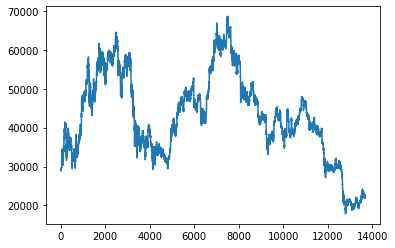

In [19]:
import matplotlib.pyplot as plt
plt.plot(data.open)
plt.show()